# CSE 881 Project

In [1]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from cvxopt import matrix 
from cvxopt import solvers

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error

In [2]:
def get_yfinance_data(ticker_list : list[str], start_date : str, end_date : str):
    """ Get data from yfinance for a list of tickers.
    
    It includes Open, High, Low, Close, Adj. Close, and Volume.
    
    Args:
        ticker_list: List of ticker symbols
        start_date: Start date of the data
        end_date: End date of the data

    Returns:
        A dict mapping ticker symbols to dataframes containing the data
        fetched from yfinance
    """
    data_dict = {}

    for ticker_symbol in ticker_list:
        data = yf.download(ticker_symbol, start=start_date, end=end_date)
        data_dict[ticker_symbol] = data

    return data_dict

In [3]:
# Example tickers and dates
aapl = "AAPL"
msft = "MSFT"
tsla = "TSLA"

tickers = [aapl, msft, tsla]

start_date = "2014-01-01"
end_date = "2024-01-01"

yfinance_data_dict = get_yfinance_data(tickers, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# Example dataframe
example_df = yfinance_data_dict["AAPL"]
example_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-23,170.910004,174.009995,169.929993,173.000000,173.000000,55980100
2023-10-24,173.050003,173.669998,171.449997,173.440002,173.440002,43816600
2023-10-25,171.880005,173.059998,170.649994,171.100006,171.100006,57157000
2023-10-26,170.369995,171.380005,165.669998,166.889999,166.889999,70625300
2023-10-27,166.910004,168.960007,166.839996,168.220001,168.220001,57945269


# Feature Construction

In [5]:
# Returns
for ticker_df in yfinance_data_dict.values():
    ticker_df["Returns"] = (ticker_df["Close"] - ticker_df["Open"]) / ticker_df["Open"]

In [6]:
# Log Returns
for ticker_df in yfinance_data_dict.values():
    ticker_df["Log Returns"] = np.log(yfinance_data_dict["AAPL"]["Close"]).diff()

In [7]:
# SMA
SMA_PERIOD = 10
for ticker_df in yfinance_data_dict.values():
    ticker_df["SMA"] = ticker_df["Close"].rolling(window=SMA_PERIOD).mean()

In [8]:
# EMA
EMA_PERIOD = 10
for ticker_df in yfinance_data_dict.values():
    ticker_df["EMA"] = ticker_df["Close"].ewm(span=EMA_PERIOD, adjust=False).mean()

In [9]:
# VWAP
for ticker_df in yfinance_data_dict.values():
    value = ticker_df["Close"] * ticker_df["Volume"]
    cumulative_value = value.cumsum()
    cumulative_volume = ticker_df["Volume"].cumsum()
    ticker_df["VWAP"] = cumulative_value / cumulative_volume

In [10]:
# CCI
CCI_PERIOD = 10
for ticker_df in yfinance_data_dict.values():
    typical_price = (ticker_df["High"] + ticker_df["Low"] + ticker_df["Close"]) / 3
    mean_typical_price = typical_price.rolling(window=CCI_PERIOD).mean()
    mean_deviation = (typical_price - mean_typical_price).abs().rolling(window=CCI_PERIOD).mean()
    
    ticker_df["CCI"] = (typical_price - mean_typical_price) / (0.015 * mean_deviation)

In [11]:
# Volatility
VOLATILITY_PERIOD  = 10
for ticker_df in yfinance_data_dict.values():
    ticker_df["Volatility"] = ticker_df["Returns"].rolling(window=VOLATILITY_PERIOD).std()

In [12]:
# RoC
ROC_PERIOD  = 10
for ticker_df in yfinance_data_dict.values():
    ticker_df["RoC"] = (ticker_df["Close"] / ticker_df["Close"].shift(ROC_PERIOD) - 1) * 100

In [13]:
# Drop rows with NAs that resulted from rolling window calculations
target_label = "Returns"
for ticker_df in yfinance_data_dict.values():
    ticker_df.drop(["Open", "High", "Low", "Close", "Adj Close"], axis = 1, inplace=True)
    ticker_df.dropna(inplace=True)
    target = ticker_df.pop("Returns")
    ticker_df["Returns"] = target

In [14]:
# Example dataframe after feature construction
example_df.tail()

,Volume,Log Returns,SMA,EMA,VWAP,CCI,Volatility,RoC,Returns
Date,,,,,,,,,
2023-10-23,55980100,0.000694,177.080002,175.653242,59.885396,-101.787165,0.009264,-3.346559,0.012229
2023-10-24,43816600,0.002540,176.585002,175.250835,59.899969,-81.139173,0.009271,-2.774818,0.002254
2023-10-25,57157000,-0.013584,175.715002,174.496139,59.918583,-93.001260,0.008978,-4.838708,-0.004538
2023-10-26,70625300,-0.024913,174.333002,173.113204,59.940703,-138.129612,0.010858,-7.647616,-0.020426
2023-10-27,57945269,0.007938,173.270001,172.223531,59.959071,-105.661752,0.010486,-5.943531,0.007849


In [15]:
# Split and preprocess the data separately to avoid data leakage
def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset)-window_size):
        features, target = dataset[i:i+window_size], dataset[i+window_size, -1]
        X.append(features)
        y.append(target)
    return torch.tensor(np.array(X)).float(), torch.tensor(np.array(y)).float().reshape(-1,1)

X = example_df.to_numpy()

TRAIN_PROPORTION = 0.9
train_size = int(TRAIN_PROPORTION * X.shape[0])

train, test = X[:train_size], X[train_size:]

train_scaler = RobustScaler() #  MinMaxScaler(feature_range=(-1,1))
train_dataset = train_scaler.fit_transform(train) 

test_scaler = RobustScaler() # MinMaxScaler(feature_range=(-1,1))
test_dataset = test_scaler.fit_transform(test) 

WINDOW_SIZE = 10
X_train, y_train = create_dataset(train_dataset, window_size=WINDOW_SIZE)
X_test, y_test = create_dataset(test_dataset, window_size=WINDOW_SIZE)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([2199, 10, 9]),
 torch.Size([2199, 1]),
 torch.Size([236, 10, 9]),
 torch.Size([236, 1]))

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = self.input_dim, 
                            hidden_size = self.hidden_dim, 
                            num_layers=self.num_layers, 
                            batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_dim, out_features=output_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0)) 
        out = self.linear(hn[-1]) # Last hidden state
        
        return out

In [17]:
HIDDEN_DIM = 64
LR = 0.0005
N_EPOCHS = 300
BATCH_SIZE = 16

model = LSTM(input_dim=X_train.shape[2], hidden_dim=HIDDEN_DIM, num_layers=1, output_dim=1)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

torch.manual_seed(1)

loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE)

for epoch in range(N_EPOCHS+1):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch.reshape(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 20 != 0:
        continue
        
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        # Repeat column to match dimension of scaler and get only last column (target) after descaling
        y_pred_orig = train_scaler.inverse_transform(np.repeat(y_pred, X_train.shape[2], axis=-1))[:,-1] 
        y_train_orig = train_scaler.inverse_transform(np.repeat(y_train, X_train.shape[2], axis=-1))[:,-1]
        train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_pred_orig))
        print("Epoch %d: train RMSE %.4f" % (epoch, train_rmse))

Epoch 0: train RMSE 0.0139
Epoch 20: train RMSE 0.0132
Epoch 40: train RMSE 0.0117
Epoch 60: train RMSE 0.0103
Epoch 80: train RMSE 0.0093
Epoch 100: train RMSE 0.0084
Epoch 120: train RMSE 0.0073
Epoch 140: train RMSE 0.0064
Epoch 160: train RMSE 0.0057
Epoch 180: train RMSE 0.0051
Epoch 200: train RMSE 0.0045
Epoch 220: train RMSE 0.0041
Epoch 240: train RMSE 0.0034
Epoch 260: train RMSE 0.0029
Epoch 280: train RMSE 0.0026
Epoch 300: train RMSE 0.0022


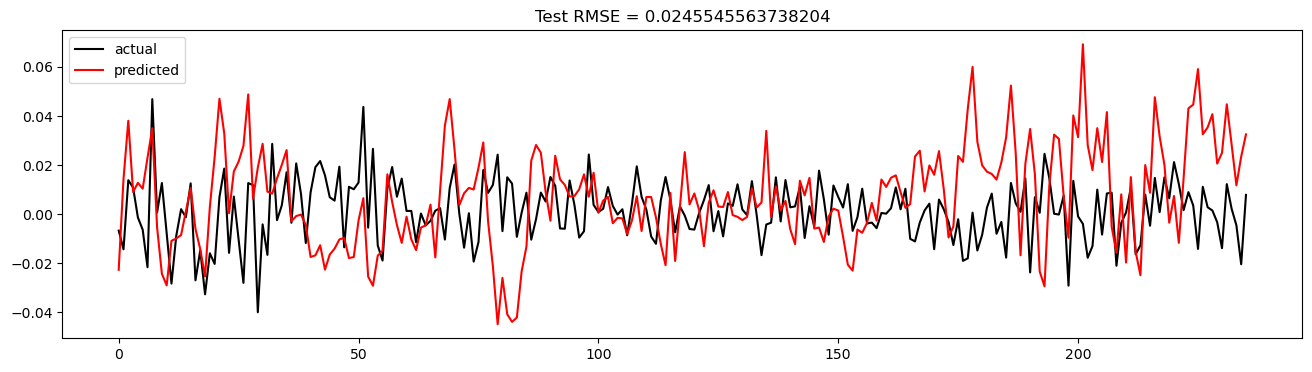

In [18]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_orig = test_scaler.inverse_transform(np.repeat(y_pred, X_test.shape[2], axis=-1))[:,-1]
    y_test_orig = test_scaler.inverse_transform(np.repeat(y_test, X_test.shape[2], axis=-1))[:,-1]
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    plt.figure(figsize=(16,4))
    plt.plot(y_test_orig, color='black', label = "actual")
    plt.plot(y_pred_orig, color='red', label = "predicted")
    plt.legend()
    plt.title('Test RMSE = ' + str(rmse))

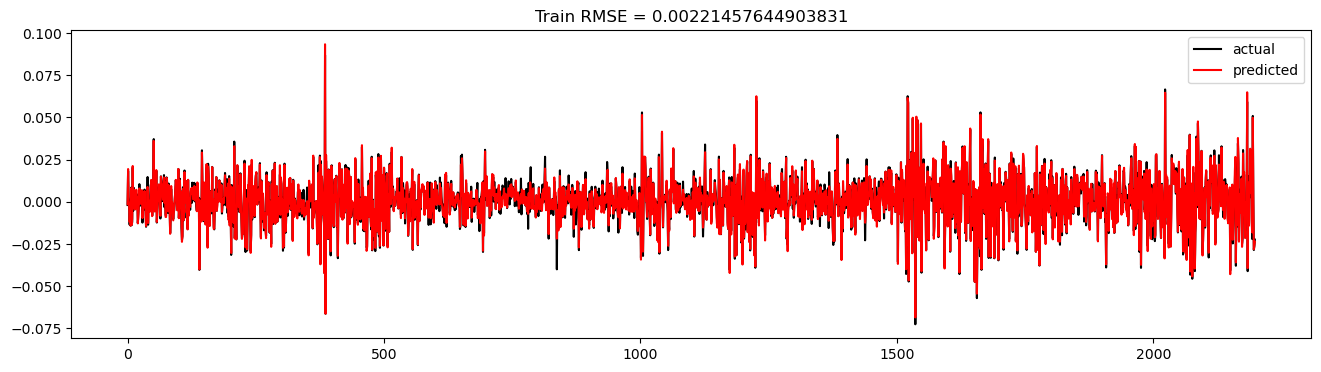

In [19]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred_orig = train_scaler.inverse_transform(np.repeat(y_pred, X_train.shape[2], axis=-1))[:,-1]
    y_train_orig = train_scaler.inverse_transform(np.repeat(y_train, X_train.shape[2], axis=-1))[:,-1]
    rmse = np.sqrt(mean_squared_error(y_train_orig, y_pred_orig))
    plt.figure(figsize=(16,4))
    plt.plot(y_train_orig, color='black', label = "actual")
    plt.plot(y_pred_orig, color='red', label = "predicted")
    plt.legend()
    plt.title('Train RMSE = ' + str(rmse))

In [20]:
# Markowitz mean-variance model
def markowitz_mean_variance(returns, covariance_matrix, risk_tolerance=0):
    """ Compute the optimal weights using the Markowitz mean-variance model.

    The goal is to maximize the expected returns of a portfolio for a given level of risk.
    Since we don't allow short selling (negative weights), we use G and h in cvxopt to indicate the inequality w_i >= 0.
    
    Args:
        returns: Returns of the tickers
        covariance_matrix: Covariance matrix of the returns of the tickers
        risk_tolerance: Risk tolerance parameter

    Returns:
        The optimal weights
    """
    P = covariance_matrix
    q = -risk_tolerance * returns
    G = -np.eye(3)
    h = np.zeros((3,1))
    A = np.array([[1.0, 1.0, 1.0]])
    b = 1.0

    P = matrix(P)
    q = matrix(q)
    G = matrix(G)
    h = matrix(h)
    A = matrix(A)
    b = matrix(b)
    
    sol = solvers.qp(P, q, G, h, A, b)
    
    return np.array(sol["x"]).squeeze()

In [21]:
def realized_profit(investment_amount, weights, returns):
    """Computes the profit of an investment given the weigths and returns.

    Args:
        investment_amount: Total investment amount
        weights: Weights corresponding to each ticker
        returns: Realized returns of each ticker

    Returns:
        Realized profit of the investment
    """
    return investment_amount * np.dot(weights, returns)

In [22]:
# Example data
investment_amount = 1000 # Input from front-end
risk_tolerance = 1 # Input from front-end
returns = np.array([ticker_df["Returns"][-1] for ticker_df in yfinance_data_dict.values()]) # Returns seen in testing data

# Profit for equally distributed weights
equal_weights = np.array([1/3]*3)
print("Equal weights:", equal_weights)
print("Profit:", realized_profit(investment_amount, equal_weights, returns))
print()

Equal weights: [0.33333333 0.33333333 0.33333333]
Profit: -3.2274044008415794



In [23]:
# Profit for Markowitz weights using both historical returns and historical covariance matrix
historical_returns = np.array([ticker_df["Returns"].mean() for ticker_df in yfinance_data_dict.values()])
historical_covariance_matrix = np.cov([ticker_df["Returns"] for ticker_df in yfinance_data_dict.values()])
historical_weights = markowitz_mean_variance(historical_returns, historical_covariance_matrix, risk_tolerance)
print("Historical weights:", historical_weights)
print("Profit:", realized_profit(investment_amount, historical_weights, returns))
print()

     pcost       dcost       gap    pres   dres
 0: -4.8024e-04 -1.0007e+00  1e+00  0e+00  2e+00
 1: -4.8030e-04 -1.0705e-02  1e-02  1e-16  2e-02
 2: -4.8601e-04 -8.0239e-04  3e-04  8e-17  7e-04
 3: -6.2535e-04 -6.9046e-04  7e-05  1e-16  3e-19
 4: -6.5351e-04 -6.5654e-04  3e-06  1e-16  2e-19
 5: -6.5615e-04 -6.5619e-04  4e-08  1e-16  1e-19
Optimal solution found.
Historical weights: [9.99831942e-01 3.15419620e-05 1.36515765e-04]
Profit: 7.845009481127695



In [24]:
# TODO: Profit for Markowitz weights using predicted returns and historical covariance matrix
predicted_returns = np.array([0.03, 0.01, -0.02]) # TODO: Use outputs from LSTMs
weights = markowitz_mean_variance(predicted_returns, historical_covariance_matrix, risk_tolerance)
print("Predicted weights:", weights)
print("Profit:", realized_profit(investment_amount, weights, returns))
print()

     pcost       dcost       gap    pres   dres
 0: -7.8315e-03 -1.0299e+00  1e+00  0e+00  2e+00
 1: -8.6155e-03 -3.9944e-02  3e-02  1e-16  7e-02
 2: -2.8791e-02 -3.3266e-02  4e-03  9e-16  3e-03
 3: -2.9871e-02 -2.9938e-02  7e-05  2e-16  5e-05
 4: -2.9904e-02 -2.9904e-02  7e-07  2e-16  5e-07
 5: -2.9904e-02 -2.9904e-02  7e-09  3e-16  5e-09
Optimal solution found.
Predicted weights: [9.99999842e-01 1.53406171e-07 5.04352926e-09]
Profit: 7.848524722519309



In [25]:
# TODO: Performance of our own model (Probabilistic classifier?)
classifier_weights = np.array([0.5, 0.3, 0.2]) # TODO: Use outputs from our own model
print("Classifier weights:", classifier_weights)
print("Profit:", realized_profit(investment_amount, classifier_weights, returns))
print()

Classifier weights: [0.5 0.3 0.2]
Profit: 0.23199427599254535

